In [1]:
from abc import abstractmethod, ABC
import torch
import gpytorch
import numpy as np
import sys 
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from matplotlib import pyplot as plt
from alfi.configuration import VariationalConfiguration
from alfi.models.lfm import LFM
from alfi.plot import Plotter1d, plot_phase, Colours
from data.generator import PVDataGenerator
from data.utils import *
from data.lfm_dataset import PV_LFM_Dataset
from models.approximate_lfm import LotkaVolterra, MultiOutputGP

In [4]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
IDX = 6
NUM_OUTPUTS = 1
NUM_LATENTS = 1
NUM_INDUCING = 100

In [5]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

X, y = generator.get_time_series()

x_train, y_train, x_test, y_test = train_test_split(X, y, n_hours=N_HOURS_PRED)

x_train[:,1] *= y_train[:,:NUM_OUTPUTS].max()
x_test[:,1] *= y_test[:,:NUM_OUTPUTS].max()

==> Loading data
==> Loaded data in: 0 m : 9 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [6]:
t_train = torch.linspace(0, 10, len(y_train))

In [7]:
dataset = PV_LFM_Dataset(num_outputs=NUM_OUTPUTS, 
                         m_observed=y_train[:, :NUM_OUTPUTS],
                         f_observed=x_train[:,1], 
                         train_t=t_train,
                         variance= 0.01 * torch.ones(NUM_OUTPUTS, dtype=torch.float64))

In [8]:
x_min, x_max = dataset.t_observed.min(), dataset.t_observed.max()
num_training = len(dataset.t_observed)

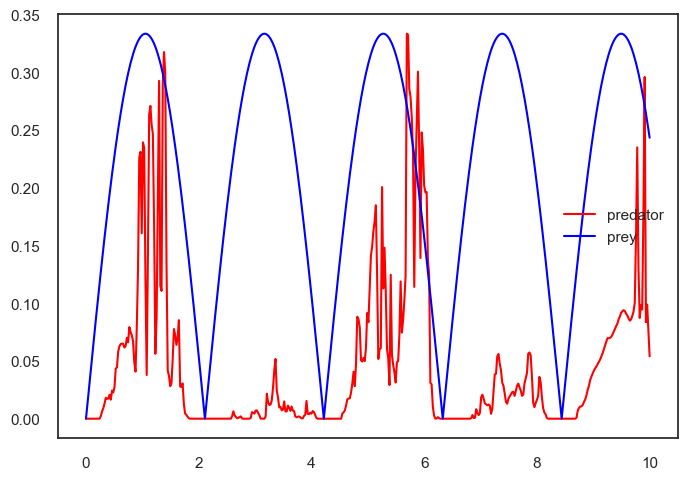

In [9]:
plt.rcParams['font.family'] = 'Arial'

plt.plot(dataset.data[0][0], dataset.data[0][1], c='red', label='predator')
plt.plot(torch.linspace(x_min, x_max, dataset.f_observed.shape[-1]), dataset.f_observed[0,0,:], c='blue', label='prey')
plt.legend()
output_names = dataset.names

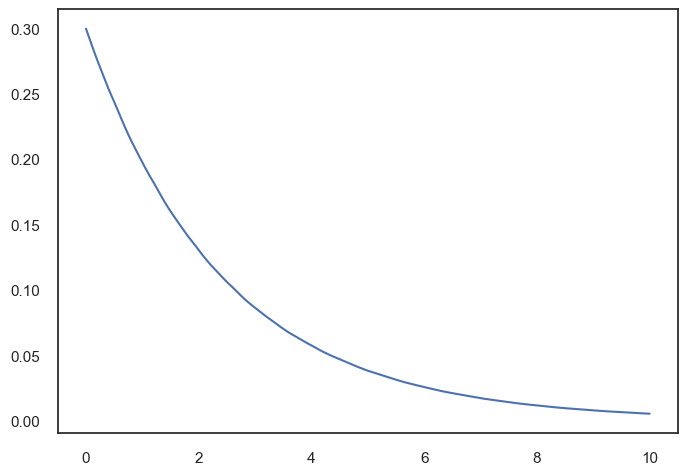

In [11]:
use_natural = False
config = VariationalConfiguration(num_samples=70)
inducing_points = torch.linspace(x_min, x_max, NUM_INDUCING).repeat(NUM_LATENTS, 1).view(
    NUM_LATENTS, NUM_INDUCING, 1)
t_predict = torch.linspace(0, x_max, 151, dtype=torch.float32)

# TODO change kernel

periodic = True
mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([NUM_LATENTS]))

track_parameters = ['raw_growth', 'raw_decay']

covar_module = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(batch_shape=torch.Size([NUM_LATENTS])),
    batch_shape=torch.Size([NUM_LATENTS])
) 
covar_module.base_kernel.lengthscale = 0.1
# covar_module.base_kernel.period_length = 0.5
track_parameters.append('gp_model.covar_module.base_kernel.raw_lengthscale')


gp_model = MultiOutputGP(mean_module, covar_module,
                         inducing_points, NUM_LATENTS,
                         natural=use_natural)


lfm = LotkaVolterra(NUM_OUTPUTS, gp_model, config, num_training_points=num_training)

plotter = Plotter1d(lfm, np.array(['predator']))
plt.rcParams['font.family'] = 'Arial'

out = lfm(t_predict, step_size=1e-1)
plt.plot(t_predict, out.mean.detach())

In [12]:
from lfm_trainer import VariationalTrainer
optimizer = [torch.optim.Adam(lfm.parameters(), lr=0.02)]

trainer = VariationalTrainer(
    lfm,
    optimizer,
    dataset,
    warm_variational=100,
    track_parameters=track_parameters,
    step_size=1/3
)

In [13]:
a = trainer.train(200, report_interval=10, step_size=3)

Epoch 001/200 - Loss: 511.84 0.00kernel: [[[0.10192055]]]
Epoch 011/200 - Loss: 480.52 0.01kernel: [[[0.0905349]]]
Epoch 021/200 - Loss: 448.58 0.01kernel: [[[0.08351412]]]
Epoch 031/200 - Loss: 415.91 0.00kernel: [[[0.07437555]]]
Epoch 041/200 - Loss: 382.77 0.00kernel: [[[0.06491]]]
Epoch 051/200 - Loss: 349.57 0.00kernel: [[[0.05588321]]]
Epoch 061/200 - Loss: 316.86 0.00kernel: [[[0.04706569]]]
Epoch 071/200 - Loss: 285.28 0.00kernel: [[[0.03940173]]]
Epoch 081/200 - Loss: 255.47 0.01kernel: [[[0.03388936]]]
Epoch 091/200 - Loss: 227.80 0.02kernel: [[[0.03280559]]]
Epoch 101/200 - Loss: 203.32 0.05kernel: [[[0.02696356]]]
Epoch 111/200 - Loss: 182.69 0.07kernel: [[[0.02841412]]]
Epoch 121/200 - Loss: 165.96 0.10kernel: [[[0.03403728]]]
Epoch 131/200 - Loss: 153.51 0.10kernel: [[[0.03688008]]]
Epoch 141/200 - Loss: 144.98 0.10kernel: [[[0.03780568]]]
Epoch 151/200 - Loss: 139.24 0.10kernel: [[[0.04109422]]]
Epoch 161/200 - Loss: 135.76 0.10kernel: [[[0.04334495]]]
Epoch 171/200 - Lo

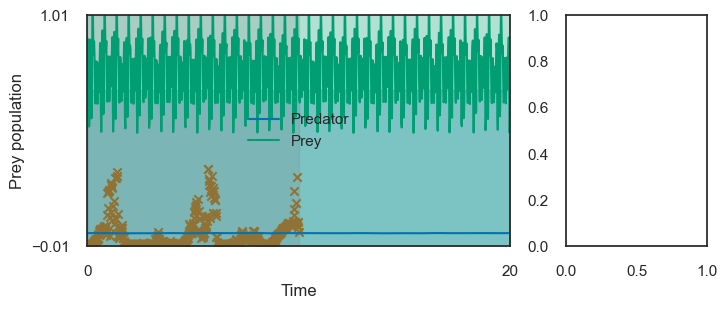

In [16]:
from alfi.utilities.torch import softplus
lfm.eval()
t_interval = (0, 20)
t_predict = torch.linspace(*t_interval, 1000, dtype=torch.float32)
t_scatter = dataset.data[0][0].unsqueeze(0).unsqueeze(0)
y_scatter = dataset.data[0][1].unsqueeze(0).unsqueeze(0)

q_m = lfm.predict_m(t_predict, step_size=5e-1)
q_f = lfm.predict_f(t_predict)
ylim = (-0.01, 1.01)

plt.rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(ncols=2,
                         figsize=(8, 3),
                         gridspec_kw=dict(width_ratios=[3, 1]))
plotter.plot_gp(q_m, t_predict, num_samples=0,
                t_scatter=t_scatter,
                y_scatter=y_scatter,
                ylim=ylim,
                titles=None, ax=axes[0])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Population')
axes[0].set_xlim(*t_interval)
# axes[0].legend()

plotter.plot_gp(q_f, t_predict,
                transform=softplus,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color,
                ylim=ylim,
                titles=None, ax=axes[0])

axes[0].set_xlabel('Time')
axes[0].set_ylabel('Prey population')
axes[0].set_xticks([t_predict[0], t_predict[-1]])
# axes[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2, integer=True))
axes[0].set_yticks([ylim[0], ylim[1]])
axes[0].fill_between(t_scatter.squeeze(), ylim[0], ylim[1], alpha=0.2, color='gray')
axes[0].get_lines()[0].set_label('Predator')
axes[0].get_lines()[1].set_label('Prey')
axes[0].legend()
